# Find rotation periods of gaia stars and make plots of parallax, etc.

In [136]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from teff_bv import teff2bv
import barnes as bn
from astropy import units as u
from astropy.coordinates import SkyCoord, Galactic
import gala.dynamics as gd

In [36]:
def match(id1, id2):
    """
    id1 = small
    id2 = big
    """
    matched = []
    inds1, inds2 = [], []
    for i, id in enumerate(id1):
        m = id2 == id
        if len(id2[m]):
            matched.append(id)
            inds2.append(int(np.where(m)[0]))
            inds1.append(i)
    return matched, inds1, inds2

In [68]:
# load matched tgas catalogue
tgas = pd.read_csv("ruth_matched.csv")

# load Amy's catalogue
rot = pd.read_csv("data/Table_1_Periodic.txt")

# load my catalogue
# kid, periods, localph, rvar, height = np.genfromtxt("kepler_periods.txt").T
kid, periods = np.genfromtxt("kplr_periods.txt").T
print(len(periods), "Kepler-TGAS stars")

# matched, tgas_inds, rot_inds = match(tgas["kepid"], rot["KID"])
matched, tgas_inds, rot_inds = match(tgas["kepid"], kid)

10967 Kepler-TGAS stars


In [97]:
# Create data arrays.
p = np.array(rot["Prot"])[rot_inds]
t = np.array(tgas["teff"])[tgas_inds]
l = np.array(tgas["logg"])[tgas_inds]
f = np.array(tgas["feh"])[tgas_inds]
j = np.array(tgas["jmag"])[tgas_inds]
pmr = np.array(tgas["pmra"])[tgas_inds]
r = np.array(tgas["ra"])[tgas_inds]
pmd = np.array(tgas["pmdec"])[tgas_inds]
d = np.array(tgas["dec"])[tgas_inds]
plx = np.array(tgas["parallax"])[tgas_inds]

In [87]:
# calculate B-V color and rotation-age
b = teff2bv(t, l, f)
a = bn.age(p, b)

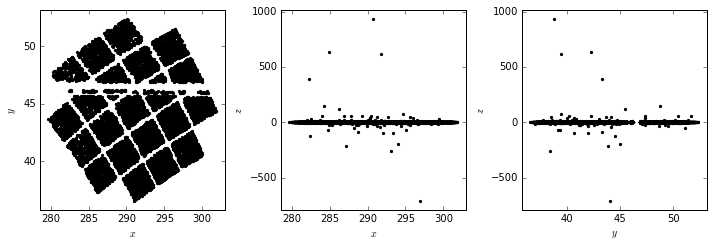

In [132]:
# calculate the z position in Kpc
c = SkyCoord(ra=r*u.deg, dec=d*u.deg, distance=(1./plx)*u.kpc)
zed = c.cartesian.z
y = c.cartesian.y
x = c.cartesian.x

# calculate velocities
mas2deg = lambda x: x/60/60/1e3
w = gd.CartesianPhaseSpacePosition(pos=[r*u.deg, d*u.deg, (1./plx)*u.kpc], vel=[pmr*u.mas/u.year, pmd*u.mas/u.year, np.zeros_like(pmr)*u.kpc/u.year])
fig = w.plot()

In [138]:
from astropy.coordinates import CylindricalRepresentation
cyl_pos, cyl_vel = w.represent_as(CylindricalRepresentation)
print(cyl_vel)

[[ 3.80654287 -3.3711177   3.41787589 ..., -7.02514464 -8.27607773
   2.17902936]
 [ 1.75192211  1.64075553  2.82257172 ..., -1.23287923  2.25942687
  -2.98333205]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


In [98]:
# remove giants, hot stars and bad data
m = (l > 4.35) * (t < 5800) * (t > 3800) * (plx > 0)
periods, teff, logg = p[m], t[m], l[m]
pmra, pmdec, parallax = pmr[m], pmd[m], plx[m]
jmag = j[m]
bv, age, z = b[m], a[m], zed[m]
ra, dec = r[m], d[m]
print(len(periods), "stars remaining after cuts")

394 stars remaining after cuts


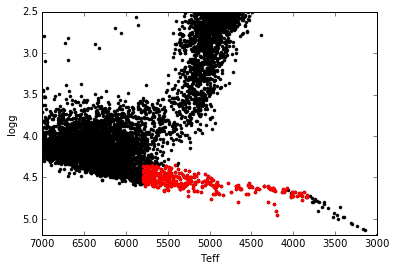

In [99]:
# plot full Kepler-TGAS HR diagram + cuts
plt.plot(t, l, "k.")
plt.xlim(7000, min(t))
plt.ylim(max(l), 2.5)
plt.plot(teff, logg, "r.")
#plt.xlim(7000, min(teff))
#plt.ylim(max(logg), min(logg))
plt.xlabel("Teff")
plt.ylabel("logg")

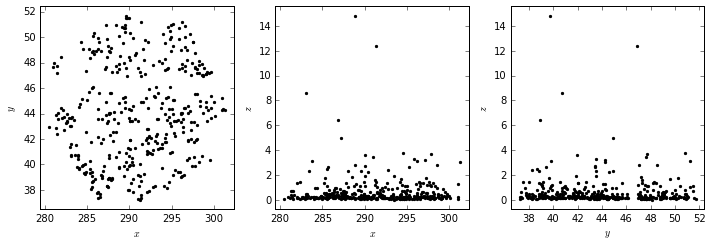

In [100]:
# replot positions
w = gd.CartesianPhaseSpacePosition(pos=[ra*u.deg, dec*u.deg, 1./parallax*u.kpc], vel=[pmra*u.mas/u.year, pmdec*u.mas/u.year, np.zeros_like(pmra)*u.kpc/u.year])
fig = w.plot()

(0, 4)

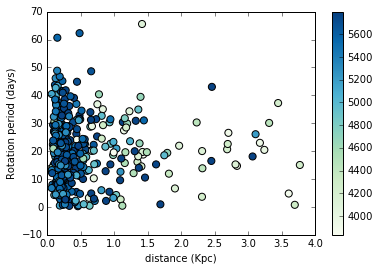

In [101]:
# plot distance vs period
plt.scatter(1./parallax, periods, s=50, c=teff, cmap="GnBu", label="Teff")
plt.colorbar()
plt.xlabel("distance (Kpc)")
plt.ylabel("Rotation period (days)")
plt.xlim(0, 4)

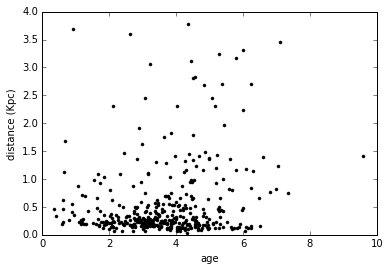

In [102]:
# plot age vs distance
plt.plot(age, 1./parallax, "k.")
plt.ylabel("distance (Kpc)")
plt.ylim(0, 4)
plt.xlabel("age")

(0, 4)

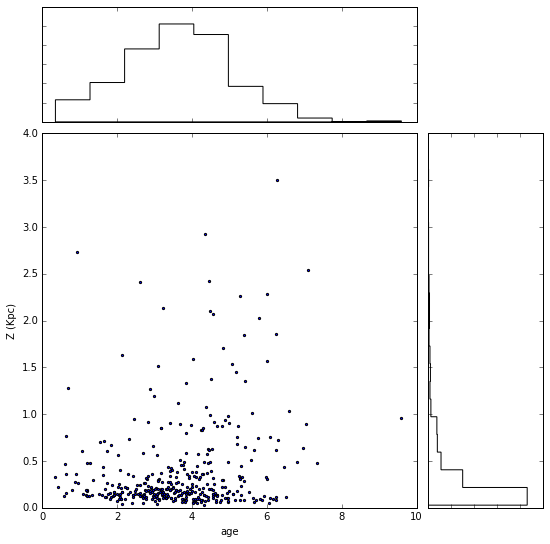

In [121]:
# plot age vs z

# scatter plot variables and settings
from matplotlib.ticker import NullFormatter
left, width = .1, .65
bottom, height = .1, .65
bottom_h = left_h = left + width + .02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, .2]
rect_histy = [left_h, bottom, .2, height]
plt.figure(1, figsize=(8, 8))
axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)
nullfmt = NullFormatter()
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHisty.xaxis.set_major_formatter(nullfmt)

# plot scatter plot
axScatter.scatter(age, z, marker=".")
axScatter.set_ylabel("Z (Kpc)")
axScatter.set_xlabel("age")
axScatter.set_xlim(0, 10)
axScatter.set_ylim(0, 4)
#axScatter.set_yscale("log")

# plot histograms
axHistx.hist(age, histtype="stepfilled", color="w")
axHisty.hist(z, 50, histtype="stepfilled", color="w", orientation="horizontal")
axHistx.set_xlim(0, 10)
axHisty.set_ylim(0, 4)

In [143]:
# plot scatter plot
print(abs(z[0]))
plt.scatter(age, np.log(z), marker=".", color=teff, cmap="GnBu", s=50)
plt.colorbar()
plt.ylabel("log Z (Kpc)")
plt.xlabel("age")
plt.xlim(0, 10)
plt.ylim(0, 4)

0.3180636568654866 kpc


TypeError: Can only apply 'log' function to dimensionless quantities